# Error Prediction : irrelevant

In [1]:
import os, csv, pickle, gzip, torch

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#### file = pd.read_csv("data/model1/m1-0725-f18-20f-pc-testset-0728-0435.csv",na_values=" NaN")
file = read_gzip("data/data_feature/0814-f18.gz")

open gzip


### Read Files

In [2]:


def resample_df(df, n_new):
    #  https://stackoverflow.com/questions/44305794/pandas-resample-data-frame-with-fixed-number-of-rows
    # df.resample() or df.reindex method yielded wrong results always.
    # use np.interp instead for concrete results
    
    n_old, m = df.values.shape
    mat_old = df.values
    mat_new = np.zeros((n_new, m))
    x_old = np.linspace(df.index.min(), df.index.max(), n_old)
    x_new = np.linspace(df.index.min(), df.index.max(), n_new)

    for j in range(m):
        y_old = mat_old[:, j]
        y_new = np.interp(x_new, x_old, y_old)
        mat_new[:, j] = y_new
    x_new = np.arange(n_new)

    return pd.DataFrame(mat_new, index=x_new, columns=df.columns)   

def draw_errors_gif_all(df_result, input_result_name=None):
    """
    SUB < 16
    draw per subject errors for 3 columns in input df
    (e.g. h,v,d or x,y,z)
    """
    # 1. pick sub1-16 / grouby params / sort by (param,file,sub)
    #---------------------------------------------------------------
    df = df_result[df_result.sub_idx < 16]
    l_sub_idx = df.sub_idx.unique()
    print(l_sub_idx)
    df['param_group'] = df.groupby(['h','v','d']).ngroup() #max 36
    df = df.sort_values(by=['param_group','file_idx','sub_idx'])
    df = df.drop(['is_exclude', 'win_idx', 'win_num'], axis=1)
    df = df.drop(['h','v','d','h_p','v_p','d_p','x_p','y_p','z_p'],axis=1)
    df = df.drop(['e_h','e_v','e_d'],axis=1)
    df = df.sort_values(by=['param_group']).reset_index(drop=True)
    l_param_group = df.param_group.unique()
    print("param combo size: ", len(l_param_group))

    #2. for each param group, resample at (file_idx, sub_idx) level
    #---------------------------------------------------------------
    new_frames = 10
    l_df_param = []
    for i, grp_idx in enumerate(l_param_group):
        
    #2-1. for each df_param, groupby by (sub, file)
        df_param = df.loc[df.param_group == grp_idx].reset_index(drop=True)
        df_param['resample_group'] = df_param.groupby(['sub_idx', 'file_idx']).ngroup()
        df_param = df_param.sort_values(by=['resample_group'])
        df_param = df_param.reset_index(drop=True)
        l_resample_group = df_param.resample_group.unique()
        # 2 available subjects, 4 files each = 8


    #2-2. for each resample_group, resample frames
        l_df_resample = []
        for j, regrp_idx in enumerate(l_resample_group):
            df_resample = df_param.loc[df_param.resample_group==regrp_idx]
            df_resample = resample_df(df_resample, new_frames)
            df_resample = df_resample.reset_index(drop=True) #essential
            l_df_resample.append(df_resample)
    #2-3. all member of one param_group has 10-frame index
    #2-3. now one_param_group is made into a single 10-frame df
        df_resample = pd.concat(l_df_resample)
        df_resample = df_resample.groupby(df_resample.index).mean()
        df_resample['e_mse'] = df_resample.groupby(df_resample.index)["e_mse"].apply(rms)
        
        l_df_param.append(df_resample)
        # resampled to framesize 10
    

    #3. make list for plot and funcanim
    #---------------------------------------------------------------
    l_x, l_y, l_z = [], [], []
    for i, df_param in enumerate(l_df_param):
        l_x.append(df_param.x.unique())
        l_y.append(df_param.y.unique())
        l_z.append(df_param.z.unique())
    
    l_file_mse = []
    for i in range(new_frames):
        file_mse =[]
        for j, file in enumerate(l_df_param):
            file_mse.append(file.loc[i].at['e_mse'])
        l_file_mse.append(file_mse)


    #------PLOT PART-------------
    # 4. plot first
    fig = plt.figure()
    title_str = '_'.join([str(elem) for i,elem in enumerate(l_sub_idx)])
    #plt.suptitle("file subjects: " + title_str, y=.995)  
    fig.set_size_inches(10,10)    
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.azim = -90#-35#-45
    ax1.elev = 87#0#65
    ax1.set_ylim(0, 4)
    scat1 = ax1.scatter(xs=l_x, ys=l_z, zs=l_y, c=l_file_mse[0], s=25, vmin=0, vmax=0.195, cmap='plasma')

    # 5. UPDATE & Funcanimation
    def Update(frame):
        ax1.clear()
        progress = 100 * (frame+1) / new_frames
        #plt.suptitle("file subjects: " + title_str, y=.995)   
        #ax1.title.set_text('Progression: '+ str(progress) + '%')
        ax1.set_xlabel("x (m)", fontsize=12)
        ax1.set_ylabel("z (m)", fontsize=12)
        ax1.set_ylim(0, 4)
        ax1.set_zlabel("y (m)", fontsize=12)
        ax1.set_zticks([])
        
        ax1.text(-0.5, 4, 3, 'Progression: ' +str(progress) +'%', fontsize=15)
        ax1.scatter(xs=l_x, ys=l_z, zs=l_y, c=l_file_mse[frame], s=90, vmin=0, cmap='plasma')
        plt.tight_layout()
        plt.savefig(str(frame)+'savefig_default.png')
        
    #------PLOT PART-------------
    
    anim = FuncAnimation(fig, Update, frames=new_frames, interval=500, blit=False)
    #cbar = plt.colorbar(scat1, pad=0.1, ax=ax1, location='bottom', fraction=0.046, pad=0.04)
    cbar = plt.colorbar(scat1, ax=ax1, orientation="horizontal", fraction=0.03, pad=-0.1)
    cbar.set_label('error(m)', fontsize=12)
    plt.tight_layout()



    if input_result_name is not None:
        print("saving")
        fname = input_result_name + "subjects_" + title_str
        f = fname + ".gif"
        print(f)
        writergif = PillowWriter(fps=2) 
        anim.save(f, writer=writergif)
        plt.close()

def rms(values):
    return np.sqrt(sum(values**2)/len(values))


def resample_df(df, n_new):
    #  https://stackoverflow.com/questions/44305794/pandas-resample-data-frame-with-fixed-number-of-rows
    # df.resample() or df.reindex method yielded wrong results always.
    # use np.interp instead for concrete results
    
    n_old, m = df.values.shape
    mat_old = df.values
    mat_new = np.zeros((n_new, m))
    x_old = np.linspace(df.index.min(), df.index.max(), n_old)
    x_new = np.linspace(df.index.min(), df.index.max(), n_new)

    for j in range(m):
        y_old = mat_old[:, j]
        y_new = np.interp(x_new, x_old, y_old)
        mat_new[:, j] = y_new
    x_new = np.arange(n_new)

    return pd.DataFrame(mat_new, index=x_new, columns=df.columns)  

def draw_errors_spatial(df_result, input_result_name=None):
    """
    SUB < 16
    draw per subject errors for 3 columns in input df
    (e.g. h,v,d or x,y,z)
    """
    # 1. pick sub1-16 / grouby params / sort by (param,file,sub)
    #---------------------------------------------------------------
    df = df_result[df_result.sub_idx < 16]
    l_sub_idx = df.sub_idx.unique()
    print(l_sub_idx)
    df['param_group'] = df.groupby(['h','v','d']).ngroup() #max 36
    df = df.sort_values(by=['param_group','file_idx','sub_idx'])
    df = df.drop(['is_exclude', 'win_idx', 'win_num'], axis=1)
    df = df.drop(['h','v','d','h_p','v_p','d_p','x_p','y_p','z_p'],axis=1)
    df = df.drop(['e_h','e_v','e_d'],axis=1)
    df = df.sort_values(by=['param_group']).reset_index(drop=True)
    l_param_group = df.param_group.unique()
    print("param combo size: ", len(l_param_group))

    #2. for each param group, resample at (file_idx, sub_idx) level
    #---------------------------------------------------------------
    new_frames = 1
    l_df_param = []
    for i, grp_idx in enumerate(l_param_group):
        
    #2-1. for each df_param, groupby by (sub, file)
        df_param = df.loc[df.param_group == grp_idx].reset_index(drop=True)
        df_param['resample_group'] = df_param.groupby(['sub_idx', 'file_idx']).ngroup()
        df_param = df_param.sort_values(by=['resample_group'])
        df_param = df_param.reset_index(drop=True)
        l_resample_group = df_param.resample_group.unique()
        # 2 available subjects, 4 files each = 8


    #2-2. for each resample_group, mean frames
        l_df_resample = []
        for j, regrp_idx in enumerate(l_resample_group):
            df_resample = df_param.loc[df_param.resample_group==regrp_idx]
            df_resample = resample_df(df_resample, new_frames)
            #df_resample = df_resample.mean(axis=0) #mean for all columns
            l_df_resample.append(df_resample)
    #2-3. all member of one param_group has single-frame index
    #2-3. now one_param_group is made into a single single-frame df
        df_resample = pd.concat(l_df_resample)
        #df_resample = df_resample.groupby(df_resample.index).mean()
        df_resample_x = df_resample.groupby(df_resample.index)['x'].mean()
        df_resample_y = df_resample.groupby(df_resample.index)['y'].mean()
        df_resample_z = df_resample.groupby(df_resample.index)['z'].mean()
        df_resample_mse = df_resample.groupby(df_resample.index)['e_mse'].apply(rms)
        df_resample = pd.DataFrame([df_resample_x, df_resample_y, df_resample_z, df_resample_mse]).transpose()
        
        
        l_df_param.append(df_resample)
        # resampled to framesize 10
    

    #3. make list for plot and funcanim
    #---------------------------------------------------------------
    l_x, l_y, l_z = [], [], []
    for i, df_param in enumerate(l_df_param):
        l_x.append(df_param.x.unique())
        l_y.append(df_param.y.unique())
        l_z.append(df_param.z.unique())
    
    l_file_mse = []
    for i in range(new_frames):
        file_mse =[]
        for j, file in enumerate(l_df_param):
            file_mse.append(file.loc[i].at['e_mse'])
        l_file_mse.append(file_mse)


    #------PLOT PART-------------
    # 4. plot first
    fig = plt.figure()
    title_str = '_'.join([str(elem) for i,elem in enumerate(l_sub_idx)])
    #plt.suptitle("file subjects: " + title_str, y=.995)  
    fig.set_size_inches(10,10)    
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.azim = -90#-35#-45
    ax1.elev = 87#0#65
    ax1.set_ylim(0, 4)
    scat1 = ax1.scatter(xs=l_x, ys=l_z, zs=l_y, c=l_file_mse[0], s=25, vmin=0, vmax=0.195, cmap='plasma')

    # 5. UPDATE & Funcanimation
    def Update(frame):
        ax1.clear()
        progress = 100 * (frame+1) / new_frames
        #plt.suptitle("file subjects: " + title_str, y=.995)   
        #ax1.title.set_text('Progression: '+ str(progress) + '%')
        ax1.set_xlabel("x (m)", fontsize=12)
        ax1.set_ylabel("z (m)", fontsize=12)
        ax1.set_ylim(0, 4)
        ax1.set_zlabel("y (m)", fontsize=12)
        ax1.set_zticks([])
        
        ax1.text(-0.5, 4, 3, 'Progression: ' +str(progress) +'%', fontsize=15)
        ax1.scatter(xs=l_x, ys=l_z, zs=l_y, c=l_file_mse[frame], s=90, vmin=0, cmap='plasma')
        plt.tight_layout()
        plt.savefig(str(frame)+'savefig_default.png')
        
    #------PLOT PART-------------
    
    anim = FuncAnimation(fig, Update, frames=new_frames, interval=500, blit=False)
    #cbar = plt.colorbar(scat1, pad=0.1, ax=ax1, location='bottom', fraction=0.046, pad=0.04)
    cbar = plt.colorbar(scat1, ax=ax1, orientation="horizontal", fraction=0.03, pad=-0.1)
    cbar.set_label('error(m)', fontsize=12)
    plt.tight_layout()



    if input_result_name is not None:
        print("saving")
        fname = input_result_name + "subjects_" + title_str
        f = fname + ".gif"
        print(f)
        writergif = PillowWriter(fps=2) 
        anim.save(f, writer=writergif)
        plt.close()        

### Define Grid Functions

In [3]:

%pylab qt
input_result_name = input("4_results: ") + ".csv"
#draw_errors_gif_all(file, input_result_name)
#draw_errors_gif_all(file, None)
input_result_name2 = input("2_4_results: ") + ".csv"
draw_errors_spatial(file, input_result_name2)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


4_results:  m1-0725-f18-5f-pc-testset-0728-0434
2_4_results:  kkk


AttributeError: 'list' object has no attribute 'sub_idx'

### Animate Skeletons

In [3]:
def resample_df(df, n_new):
    #  https://stackoverflow.com/questions/44305794/pandas-resample-data-frame-with-fixed-number-of-rows
    # df.resample() or df.reindex method yielded wrong results always.
    # use np.interp instead for concrete results
    
    n_old, m = df.values.shape
    mat_old = df.values
    mat_new = np.zeros((n_new, m))
    x_old = np.linspace(df.index.min(), df.index.max(), n_old)
    x_new = np.linspace(df.index.min(), df.index.max(), n_new)

    for j in range(m):
        y_old = mat_old[:, j]
        y_new = np.interp(x_new, x_old, y_old)
        mat_new[:, j] = y_new
    x_new = np.arange(n_new)

    return pd.DataFrame(mat_new, index=x_new, columns=df.columns)   

def draw_conf_errors_all(df, input_result_name=None):
    new_frames = 20
    # one temporal plot for whole dataset
    l_sub_idx = df.sub_idx.unique()

    df['sub_group'] = df.groupby(['sub_idx']).ngroup() # 4 for evaluation
    df = df.sort_values(by=['file_idx','sub_idx']) #only files and subject
    l_sub_group = df.sub_group.unique()
    
    df['resample_group'] = df.groupby(['sub_idx', 'file_idx']).ngroup()          

    l_resample_group = df.resample_group.unique()
    
    # sort all frames in each group and resample, and then append each 10-frame-list
    l_output = []
    l_df_resample = []
    for i, regrp_idx in enumerate(l_resample_group):
        df_resample = df.loc[df.resample_group==regrp_idx]
        df_resample = resample_df(df_resample, new_frames)
        df_resample = df_resample.reset_index(drop=True) #essential
        l_df_resample.append(df_resample)
        
    # print(df_resample)
    # now mean all respective index frame for all resample sequence
    df_resample = pd.concat(l_df_resample)
    df_resample = df_resample.groupby(df_resample.index).mean()
    
    return df_resample[["e_h","e_v", "atan_deg","h_e", "v_e","atan_deg_e"]]

In [4]:
y_b2=draw_conf_errors_all(df_b2, "eye")
y_b3=draw_conf_errors_all(df_b3, "eye")

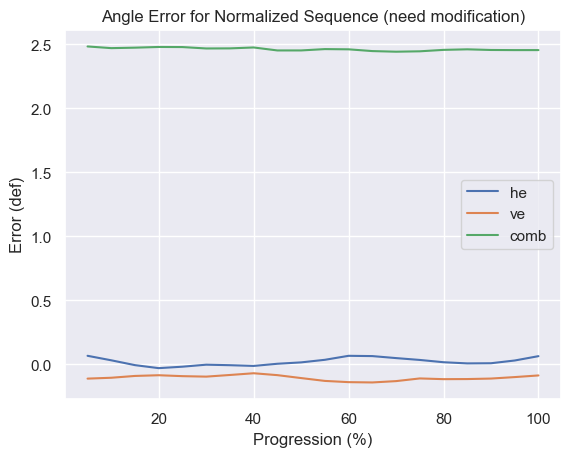

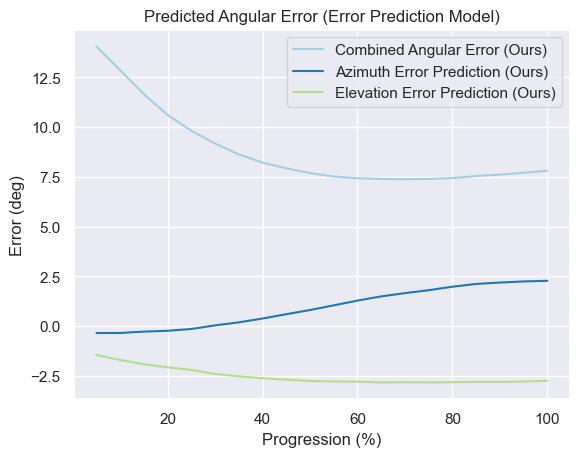

In [16]:
# print(y1, y2, y3, y4)
x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 

plt.figure()
sns.set(style='darkgrid')
plt.title('Angle Error for Normalized Sequence (need modification)')
plt.plot(x, y_b2.h_e, label = "he")
plt.plot(x, y_b2.v_e, label = "ve")
plt.plot(x, y_b2.atan_deg_e, label = "comb")
plt.xlabel('Progression (%)')
plt.ylabel('Elevation Error (Degree)')
plt.xlabel('Progression (%)')
plt.ylabel('Error (def)')
plt.legend(loc='center right')

# print(y1, y2, y3, y4)

x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 

plt.figure()
sns.set(style='darkgrid', palette='Paired')
plt.title("Predicted Angular Error (Error Prediction Model)")
plt.plot(x, y_b3.atan_deg_e, label = "Combined Angular Error (Ours)")
plt.plot(x, y_b3.h_e, label = "Azimuth Error Prediction (Ours)")
plt.plot(x, y_b3.v_e, label = "Elevation Error Prediction (Ours)")
plt.xlabel('Progression (%)')
plt.ylabel('Error (deg)')
plt.legend(loc='upper right')